In [1]:
#Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import os
from PIL import Image
from torch.cuda.amp import GradScaler
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import argparse
import itertools

In [2]:
!unzip '/content/data.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data/train/sketches/6064.jpg  
  inflating: /content/data/data/train/sketches/6065.jpg  
  inflating: /content/data/data/train/sketches/6066.jpg  
  inflating: /content/data/data/train/sketches/6067.jpg  
  inflating: /content/data/data/train/sketches/6068.jpg  
  inflating: /content/data/data/train/sketches/6069.jpg  
  inflating: /content/data/data/train/sketches/607.jpg  
  inflating: /content/data/data/train/sketches/6070.jpg  
  inflating: /content/data/data/train/sketches/6071.jpg  
  inflating: /content/data/data/train/sketches/6072.jpg  
  inflating: /content/data/data/train/sketches/6073.jpg  
  inflating: /content/data/data/train/sketches/6074.jpg  
  inflating: /content/data/data/train/sketches/6075.jpg  
  inflating: /content/data/data/train/sketches/6076.jpg  
  inflating: /content/data/data/train/sketches/6077.jpg  
  inflating: /content/data/data/train/sketches/6078.jpg  
  inflating: /content/

In [4]:
#Data Loading and Preprocessing


#Define the transformation
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#Dataset class to load sketches and photos
class SketchFaceDataset(Dataset):
    def __init__(self,base_dir,phase='train',transform=None,subset_fraction=0.5):
        self.sketch_dir=os.path.join(base_dir,phase,'sketches')
        self.original_dir=os.path.join(base_dir,phase,'photos')
        self.transform=transform
        self.sketch_files=sorted(os.listdir(self.sketch_dir))
        self.original_files=sorted(os.listdir(self.original_dir))
        subset_size=int(len(self.sketch_files)*subset_fraction)
        self.sketch_files=self.sketch_files[:subset_size]
        self.original_files=self.original_files[:subset_size]
    def __len__(self):
        return len(self.sketch_files)
    def __getitem__(self,idx):
        sketch_path=os.path.join(self.sketch_dir,self.sketch_files[idx])
        original_path=os.path.join(self.original_dir,self.original_files[idx])
        sketch=Image.open(sketch_path).convert("RGB")
        original=Image.open(original_path).convert("RGB")
        if self.transform:
            sketch=self.transform(sketch)
            original=self.transform(original)
        return sketch,original

#Dataset and Dataloaders
base_dir='/content/data/data'
train_dataset=SketchFaceDataset(base_dir,phase='train',transform=transform,subset_fraction=0.5)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_dataset=SketchFaceDataset(base_dir,phase='val',transform=transform,subset_fraction=0.5)
test_dataset=SketchFaceDataset(base_dir,phase='test',transform=transform)

In [5]:
#Generator Class

#Define the ConvolutionalBlock
class ConvolutionalBlock(nn.Module):
    def __init__(self,in_channels,out_channels,is_downsampling=True,add_activation=True,**kwargs):
        super().__init__()
        if is_downsampling:
            self.conv=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,padding_mode="reflect",**kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv=nn.Sequential(
                nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self,x):
        return self.conv(x)

#ResidualBlock class definition
class ResidualBlock(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.block=nn.Sequential(
            ConvolutionalBlock(channels,channels,add_activation=True,kernel_size=3,padding=1),
            ConvolutionalBlock(channels,channels,add_activation=False,kernel_size=3,padding=1),
        )
    def forward(self,x):
        return x+self.block(x)

#Define the Generator model
class Generator(nn.Module):
    def __init__(self,img_channels,num_features=64,num_residuals=6):
        super().__init__()
        self.initial_layer=nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7,stride=1,padding=3,padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.downsampling_layers=nn.ModuleList([
            ConvolutionalBlock(num_features,num_features*2,is_downsampling=True,kernel_size=3,stride=2,padding=1),
            ConvolutionalBlock(num_features*2,num_features*4,is_downsampling=True,kernel_size=3,stride=2,padding=1),
        ])
        self.residual_layers=nn.Sequential(*[ResidualBlock(num_features*4) for _ in range(num_residuals)])
        self.upsampling_layers=nn.ModuleList([
            ConvolutionalBlock(num_features*4,num_features*2,is_downsampling=False,kernel_size=3,stride=2,padding=1,output_padding=1),
            ConvolutionalBlock(num_features*2,num_features*1,is_downsampling=False,kernel_size=3,stride=2,padding=1,output_padding=1),
        ])
        self.last_layer=nn.Conv2d(num_features*1,img_channels,kernel_size=7,stride=1,padding=3,padding_mode="reflect")

    def forward(self,x):
        x=self.initial_layer(x)
        for layer in self.downsampling_layers:
            x=layer(x)
        x=self.residual_layers(x)
        for layer in self.upsampling_layers:
            x=layer(x)
        return torch.tanh(self.last_layer(x))

In [6]:
#Discriminator Class

#Define the Normalisation class
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.block=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=stride,padding=1,padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2,inplace=True),
        )
    def forward(self,x):
        return self.block(x)

#Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self,in_channels=3,features=[64,128,256,512]):
        super().__init__()
        self.initial_layer=nn.Sequential(
            nn.Conv2d(in_channels,features[0],kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
            nn.LeakyReLU(0.2,inplace=True),
        )
        layers=[]
        in_channels=features[0]
        for feature in features[1:]:
            layers.append(ConvInstanceNormLeakyReLUBlock(in_channels,feature,stride=1 if feature==features[-1] else 2))
            in_channels=feature
        layers.append(
            nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
        )
        self.model=nn.Sequential(*layers)
    def forward(self,x):
        x=self.initial_layer(x)
        return self.model(x)

In [7]:
#Training function
def train(disc_S,disc_P,gen_P,gen_S,loader,opt_disc,opt_gen,l1,mse,d_scaler,g_scaler,device,LAMBDA_CYCLE=10):
    H_reals=0
    H_fakes=0
    loop=tqdm(loader,leave=True)

    for idx, (skectches,photos)in enumerate(loop):
        skectches=skectches.to(device)
        photos=photos.to(device)
        #Train discriminators P and S
        with torch.cuda.amp.autocast():
            fake1=gen_S(skectches)
            D_H_real=disc_S(photos)
            D_H_fake=disc_S(fake1.detach())
            H_reals+=D_H_real.mean().item()
            H_fakes+=D_H_fake.mean().item()
            D_H_real_loss=mse(D_H_real,torch.ones_like(D_H_real))
            D_H_fake_loss=mse(D_H_fake,torch.zeros_like(D_H_fake))
            D_H_loss=D_H_real_loss+D_H_fake_loss

            fake2=gen_P(photos)
            D_Z_real=disc_P(skectches)
            D_Z_fake=disc_P(fake2.detach())
            D_Z_real_loss=mse(D_Z_real,torch.ones_like(D_Z_real))
            D_Z_fake_loss=mse(D_Z_fake,torch.zeros_like(D_Z_fake))
            D_Z_loss=D_Z_real_loss+D_Z_fake_loss
            D_loss=(D_H_loss+D_Z_loss)/2
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        #Train generators P and S
        with torch.cuda.amp.autocast():
            #Adversarial losses
            D_H_fake=disc_S(fake1)
            D_Z_fake=disc_P(fake2)
            loss_G_H=mse(D_H_fake,torch.ones_like(D_H_fake))
            loss_G_Z=mse(D_Z_fake,torch.ones_like(D_Z_fake))

            #Cycle consistency losses
            cycle1=gen_P(fake1)
            cycle2=gen_S(fake2)
            cycle1=l1(skectches,cycle1)
            cycle2=l1(photos,cycle2)

            #Total generator loss
            G_loss=loss_G_Z+loss_G_H+cycle1*LAMBDA_CYCLE+cycle2*LAMBDA_CYCLE

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        loop.set_postfix(H_real=H_reals/(idx+1),H_fake=H_fakes/(idx+1))


<ipython-input-8-a8a736e4d2e3>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler=GradScaler()
<ipython-input-8-a8a736e4d2e3>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler=GradScaler()


Epoch [1/20]


  0%|          | 0/162 [00:00<?, ?it/s]<ipython-input-7-48bf3279c11b>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-7-48bf3279c11b>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 162/162 [02:29<00:00,  1.08it/s, H_fake=0.414, H_real=0.574]


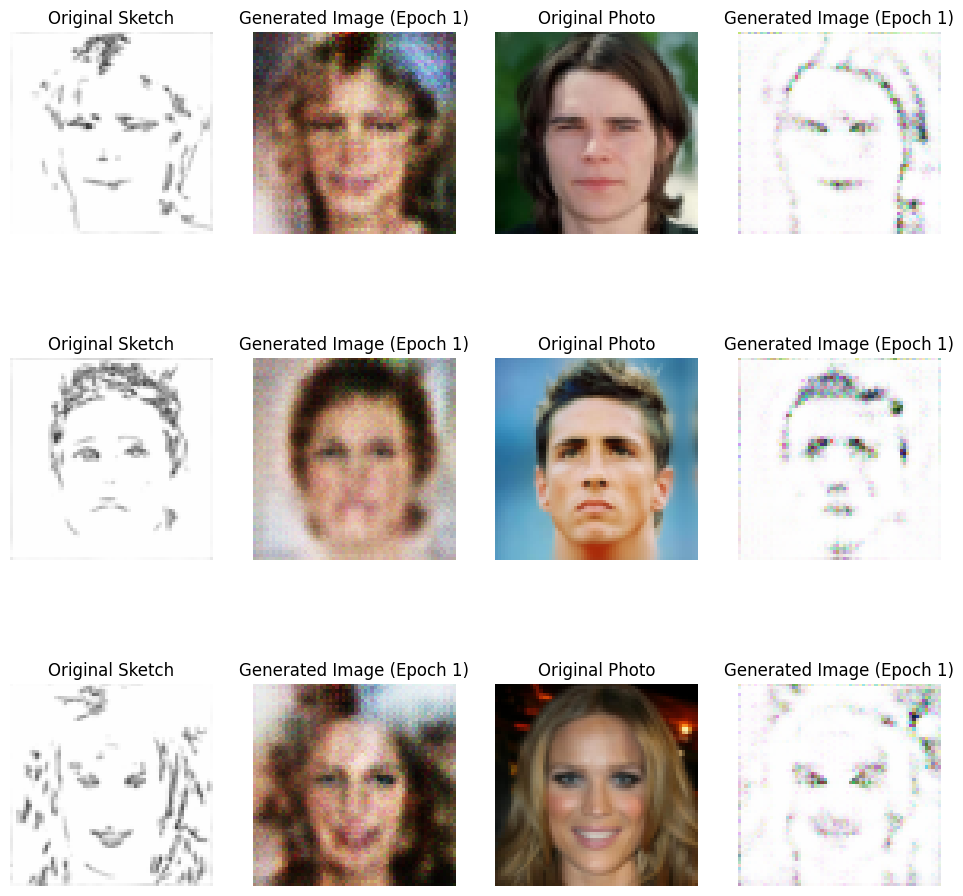

Epoch [2/20]


100%|██████████| 162/162 [02:31<00:00,  1.07it/s, H_fake=0.434, H_real=0.565]


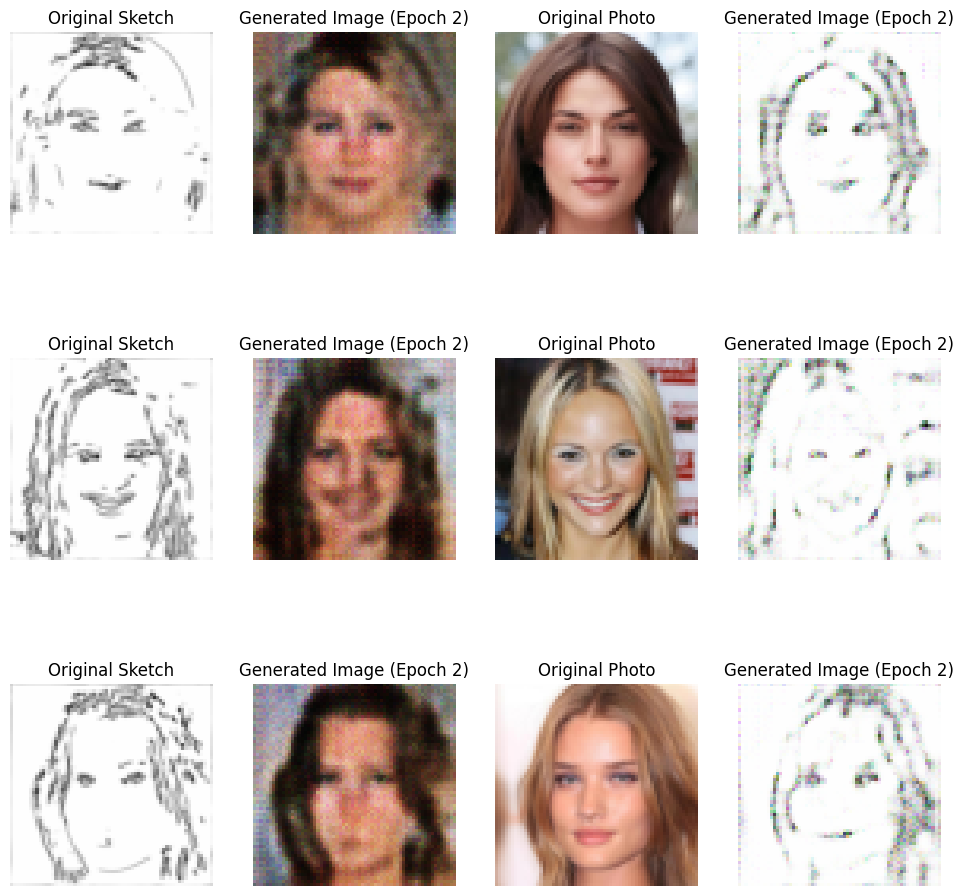

Epoch [3/20]


100%|██████████| 162/162 [02:30<00:00,  1.07it/s, H_fake=0.433, H_real=0.566]


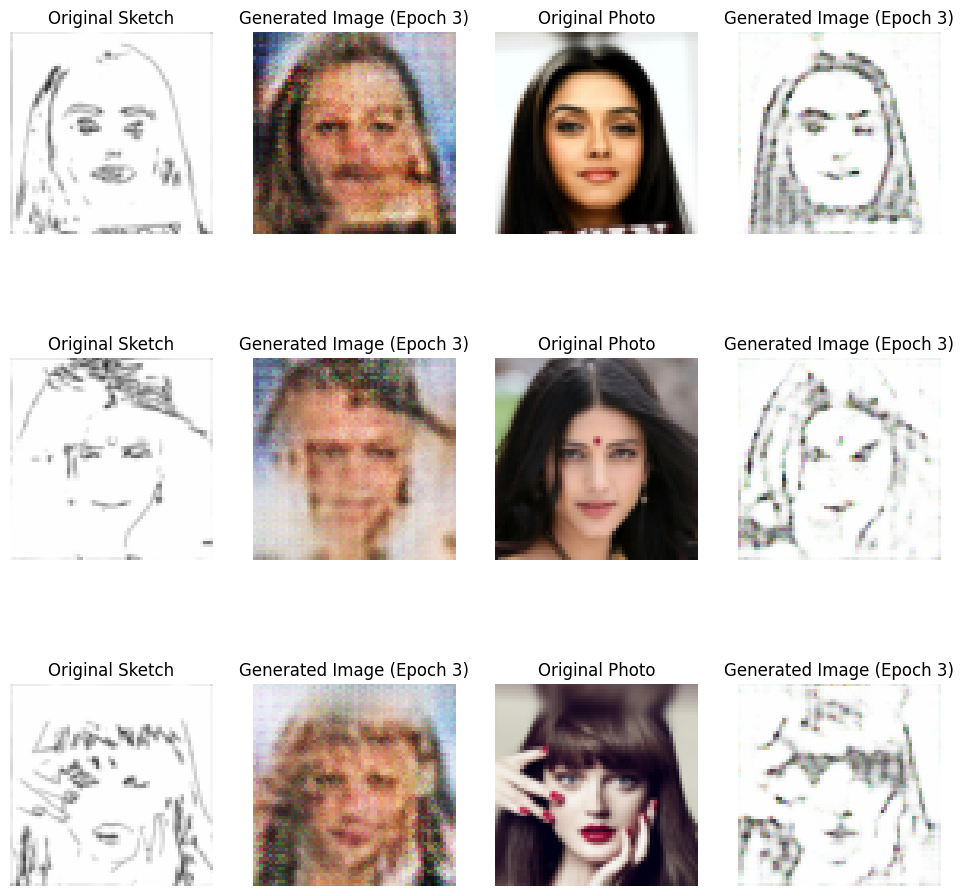

Epoch [4/20]


100%|██████████| 162/162 [02:31<00:00,  1.07it/s, H_fake=0.428, H_real=0.571]


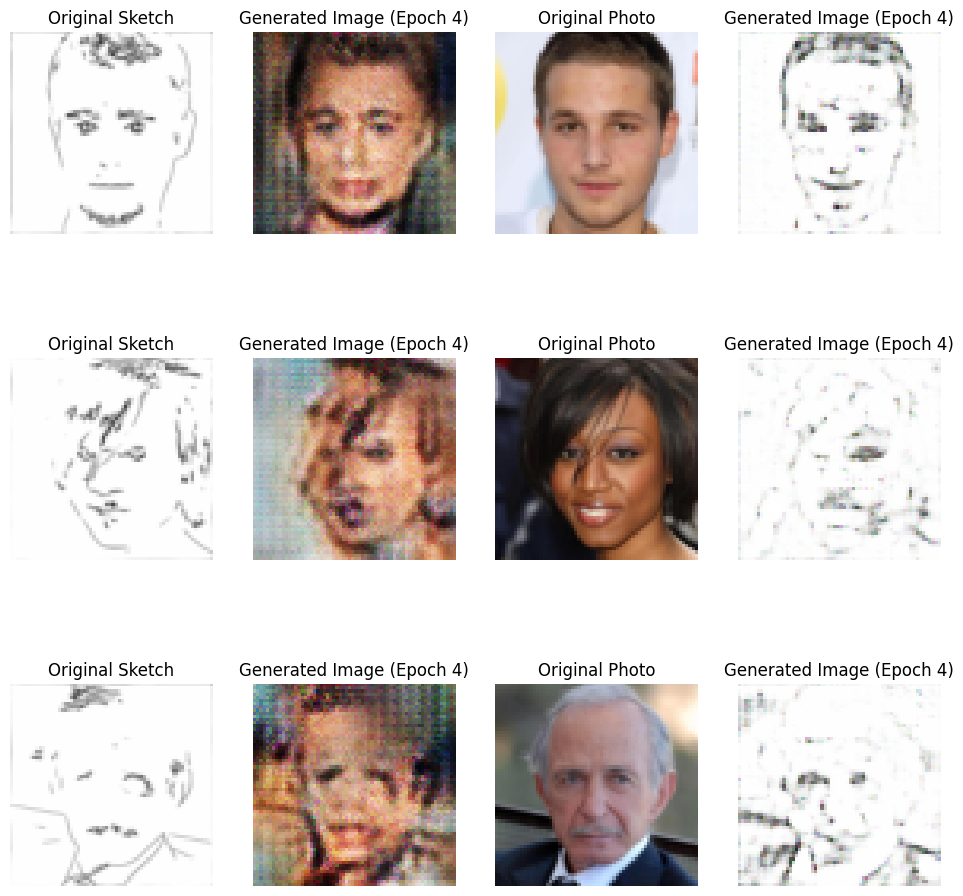

Epoch [5/20]


100%|██████████| 162/162 [02:31<00:00,  1.07it/s, H_fake=0.427, H_real=0.572]


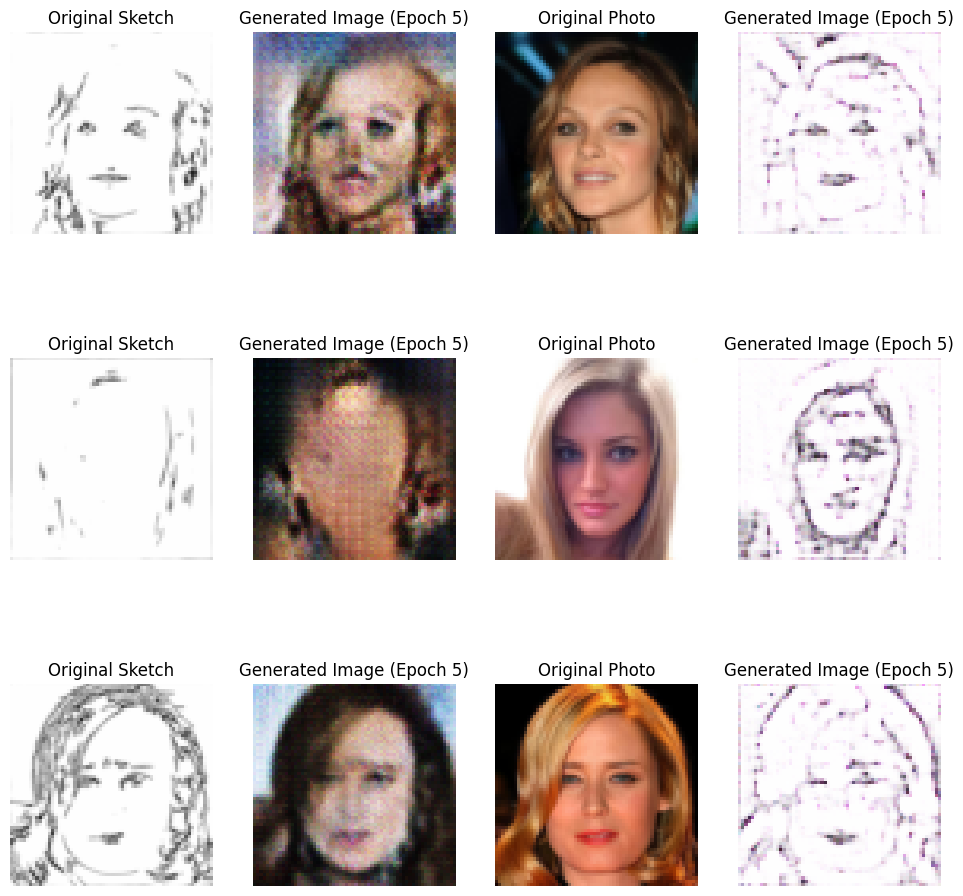

Epoch [6/20]


100%|██████████| 162/162 [02:32<00:00,  1.06it/s, H_fake=0.422, H_real=0.579]


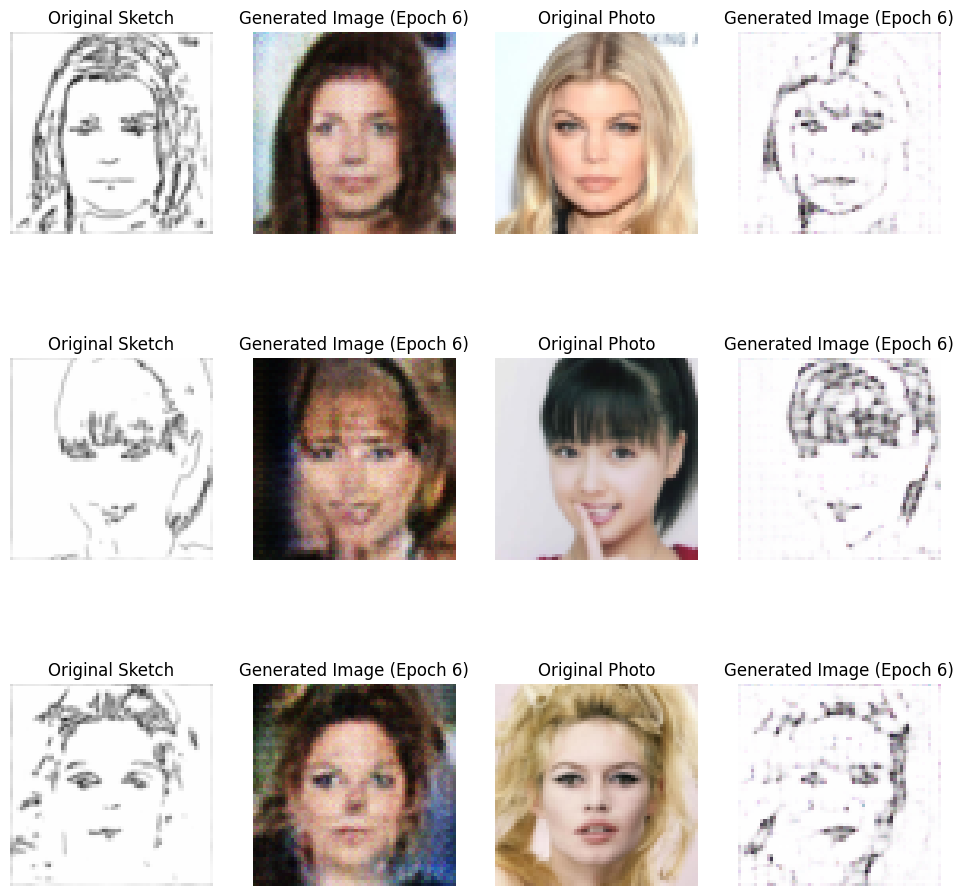

Epoch [7/20]


100%|██████████| 162/162 [02:32<00:00,  1.06it/s, H_fake=0.422, H_real=0.578]


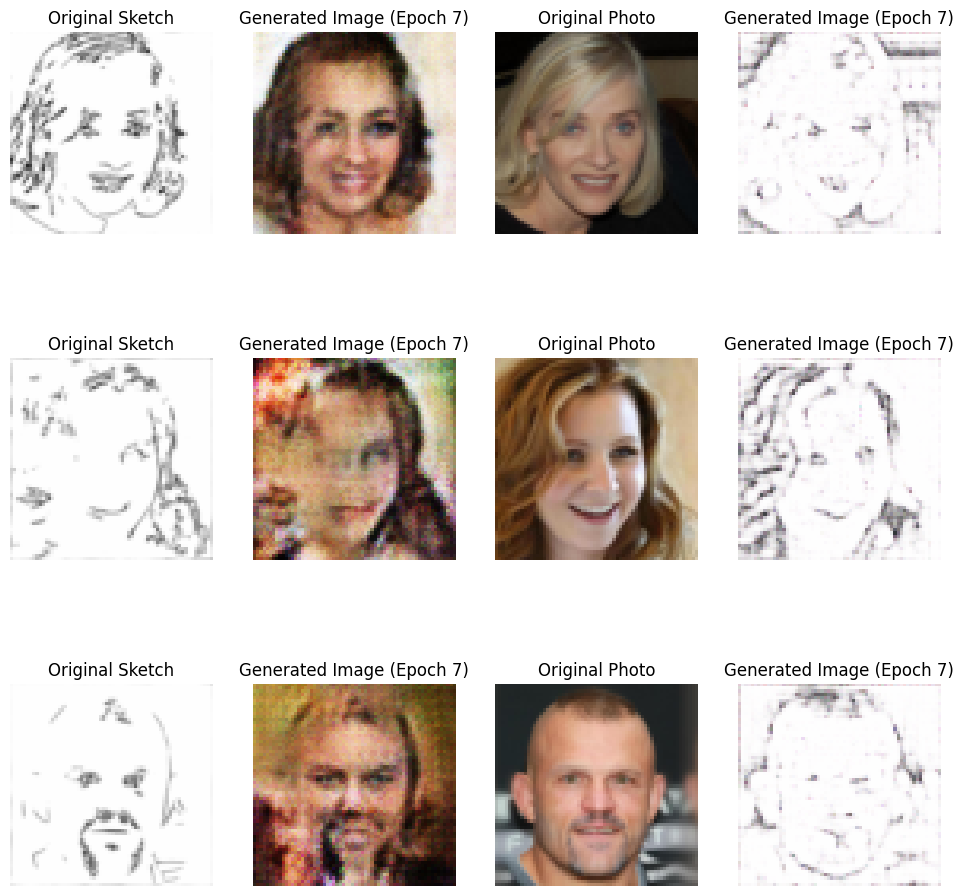

Epoch [8/20]


100%|██████████| 162/162 [02:32<00:00,  1.06it/s, H_fake=0.422, H_real=0.578]


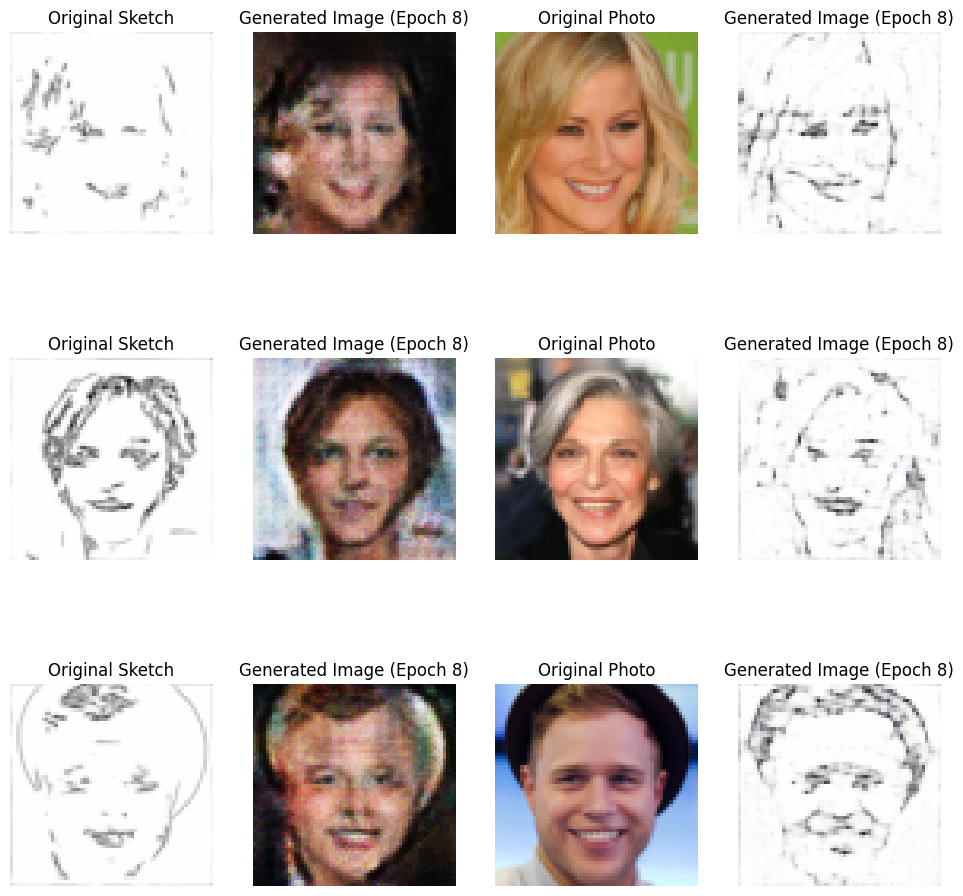

Epoch [9/20]


100%|██████████| 162/162 [02:32<00:00,  1.06it/s, H_fake=0.423, H_real=0.577]


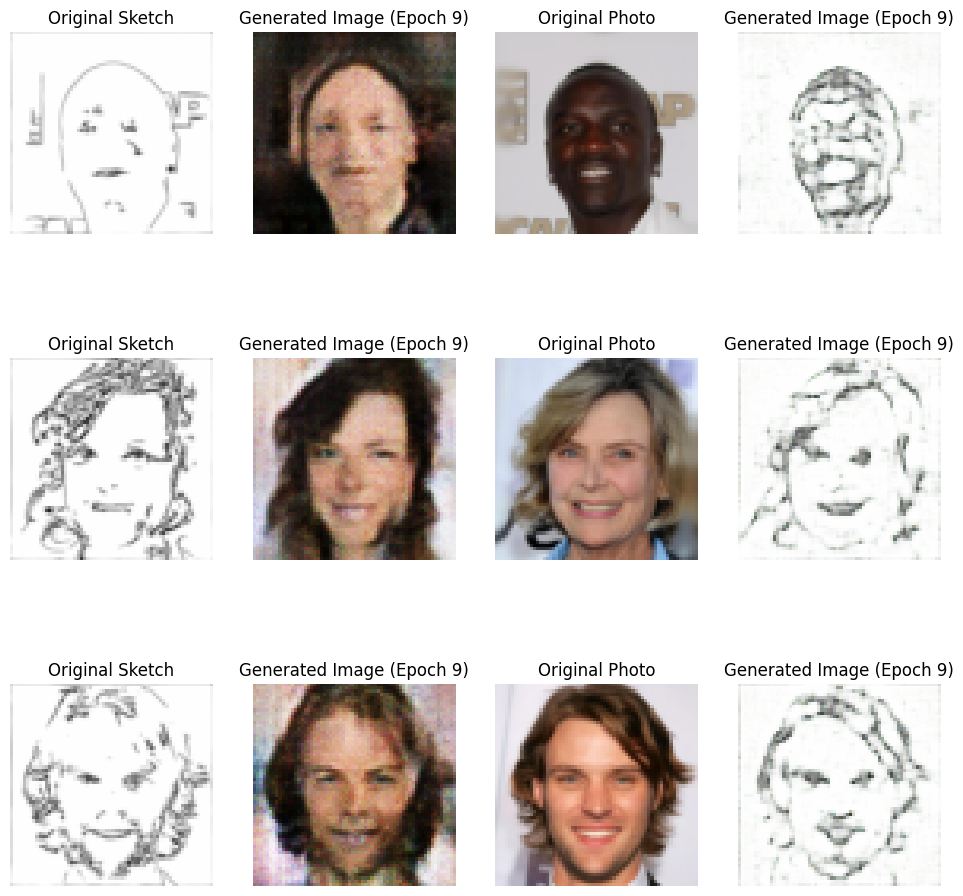

Epoch [10/20]


100%|██████████| 162/162 [02:33<00:00,  1.05it/s, H_fake=0.424, H_real=0.576]


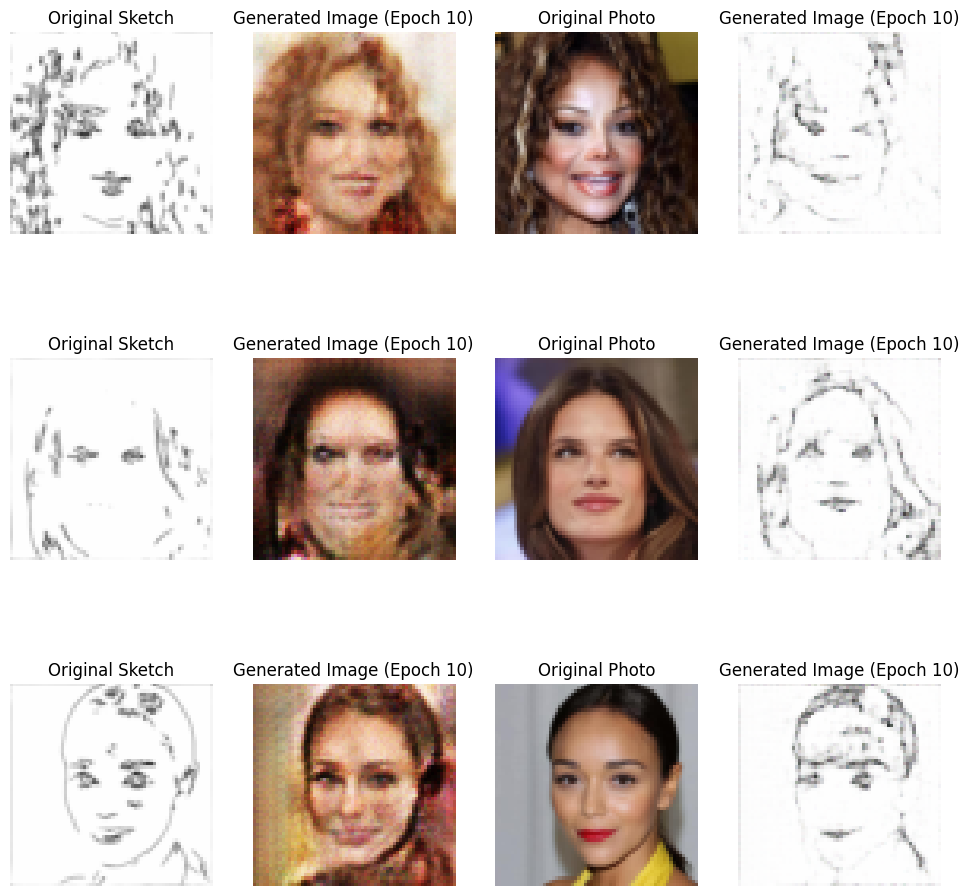

Epoch [11/20]


100%|██████████| 162/162 [02:33<00:00,  1.06it/s, H_fake=0.421, H_real=0.579]


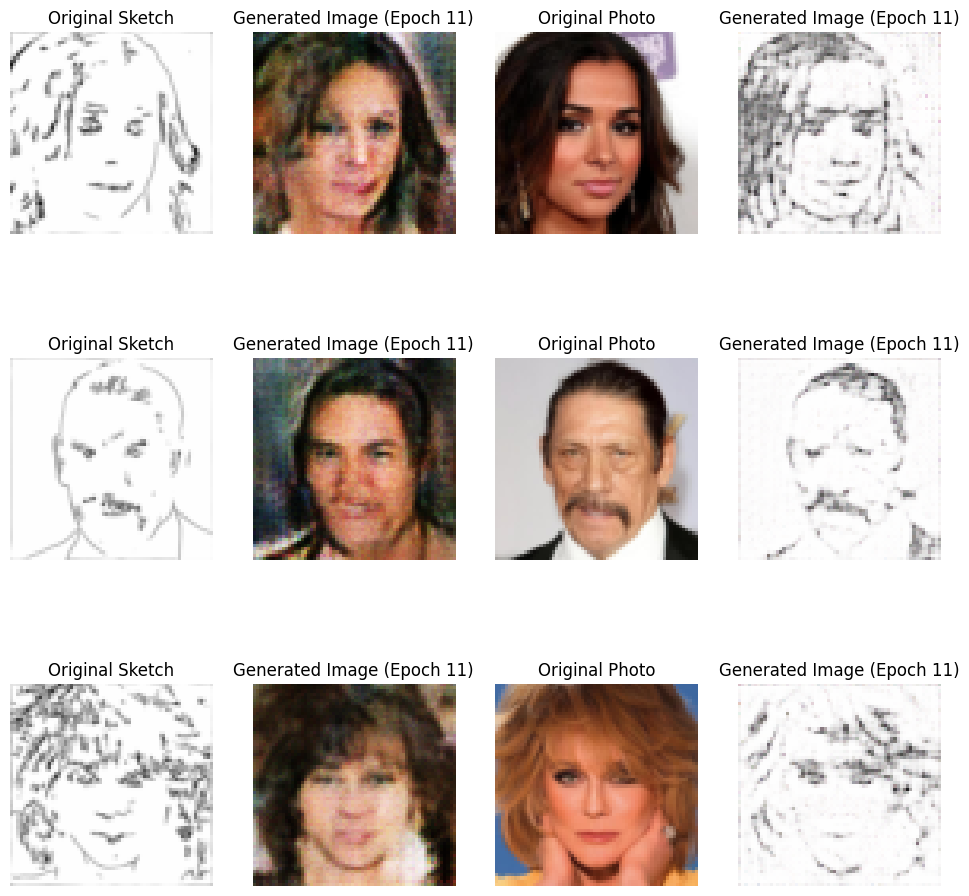

Epoch [12/20]


100%|██████████| 162/162 [02:34<00:00,  1.05it/s, H_fake=0.425, H_real=0.575]


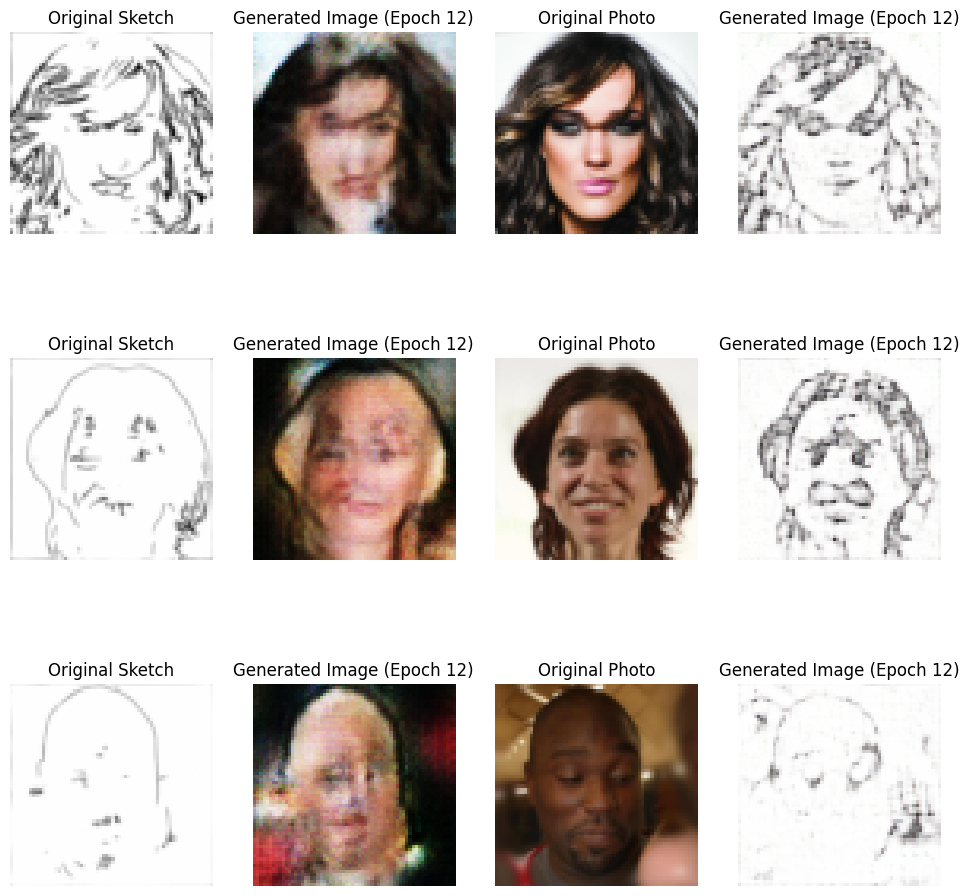

Epoch [13/20]


100%|██████████| 162/162 [02:34<00:00,  1.05it/s, H_fake=0.423, H_real=0.577]


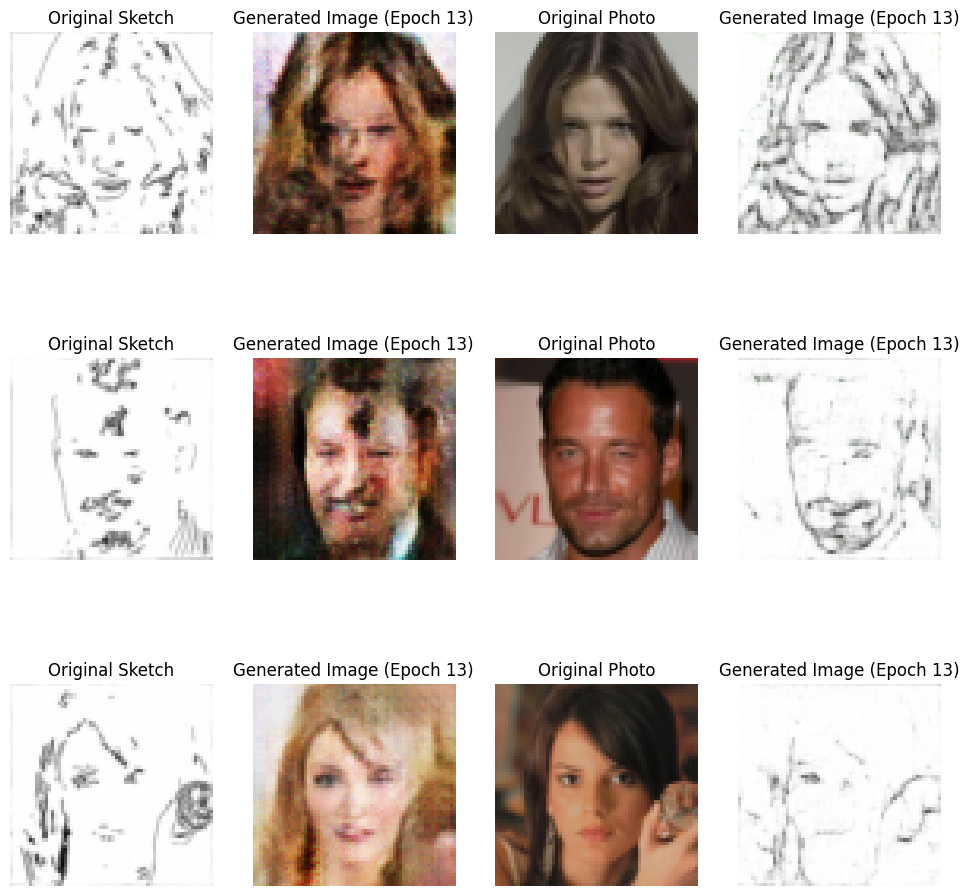

Epoch [14/20]


100%|██████████| 162/162 [02:34<00:00,  1.05it/s, H_fake=0.422, H_real=0.579]


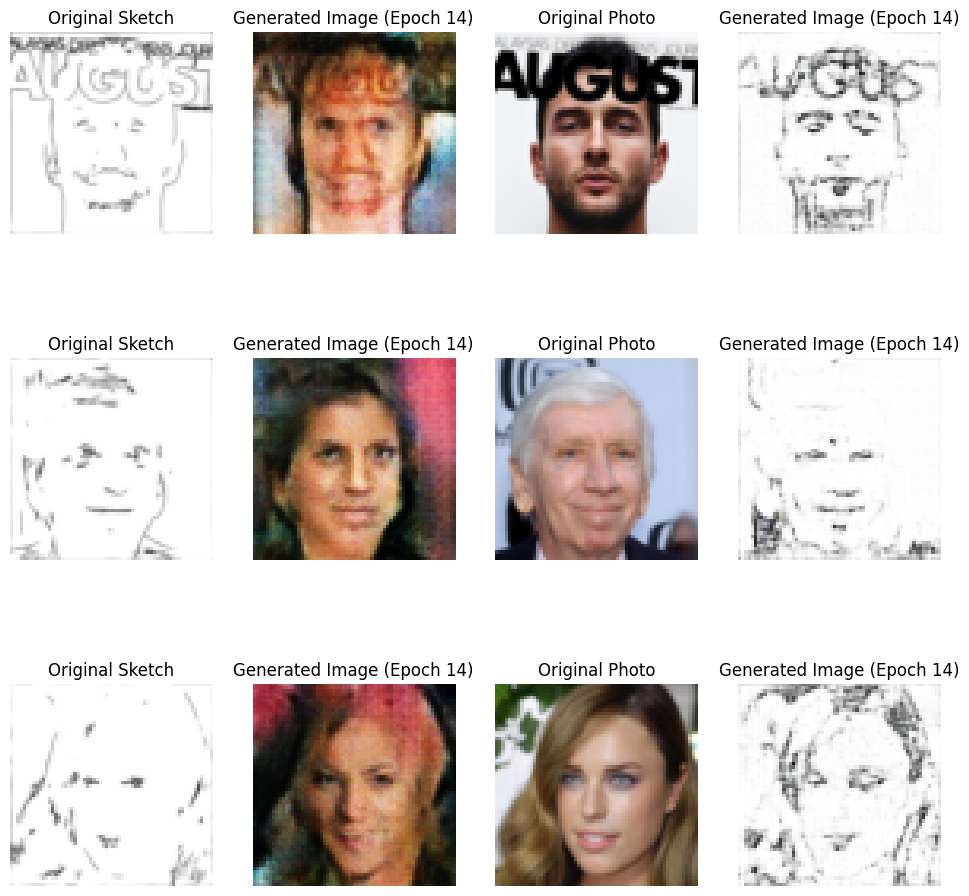

Epoch [15/20]


100%|██████████| 162/162 [02:34<00:00,  1.05it/s, H_fake=0.419, H_real=0.58]


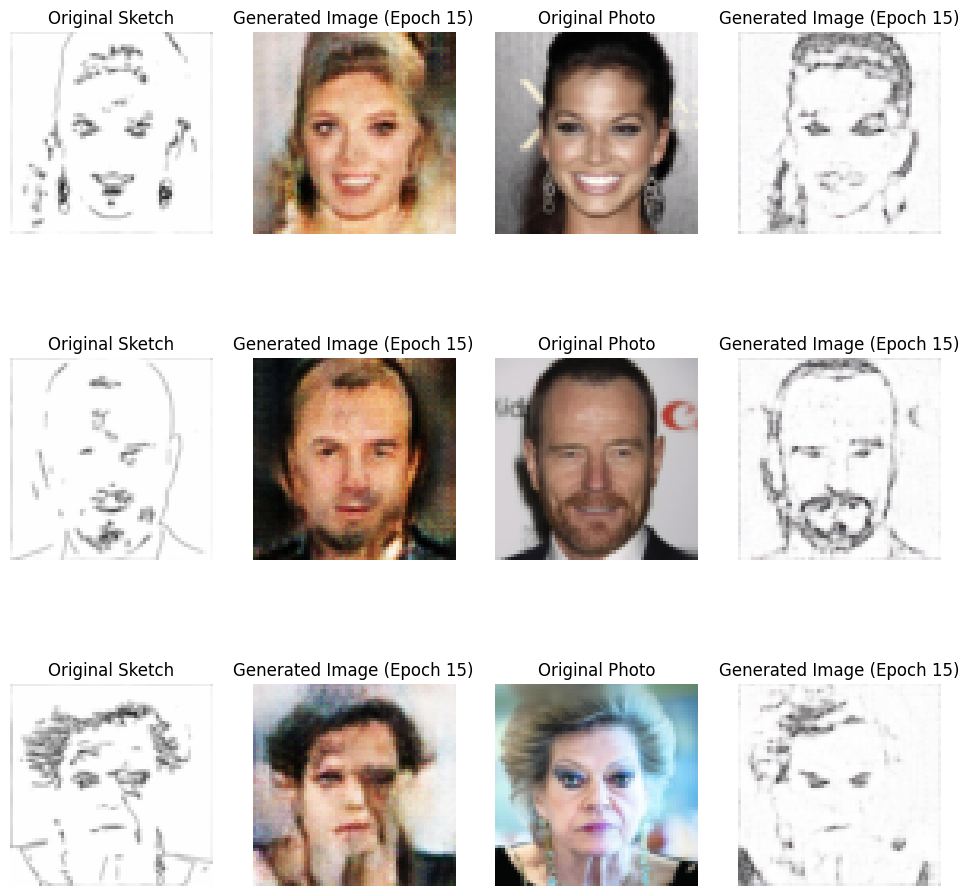

Epoch [16/20]


100%|██████████| 162/162 [02:35<00:00,  1.04it/s, H_fake=0.415, H_real=0.581]


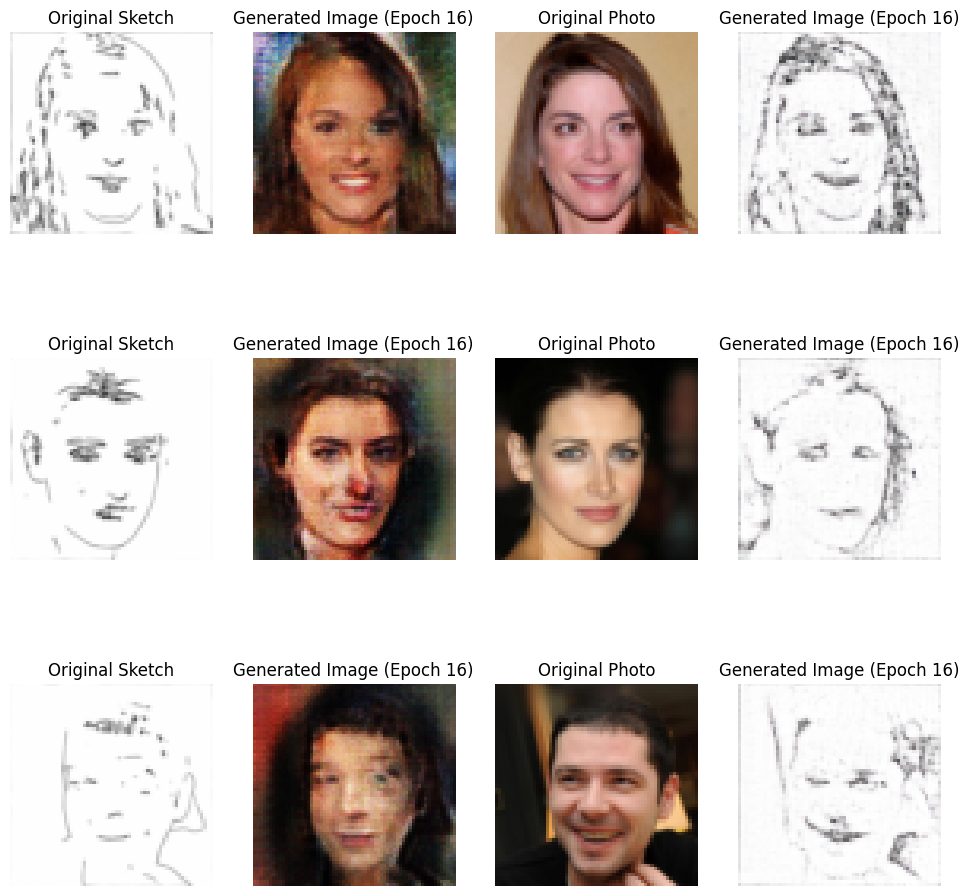

Epoch [17/20]


100%|██████████| 162/162 [02:35<00:00,  1.04it/s, H_fake=0.417, H_real=0.584]


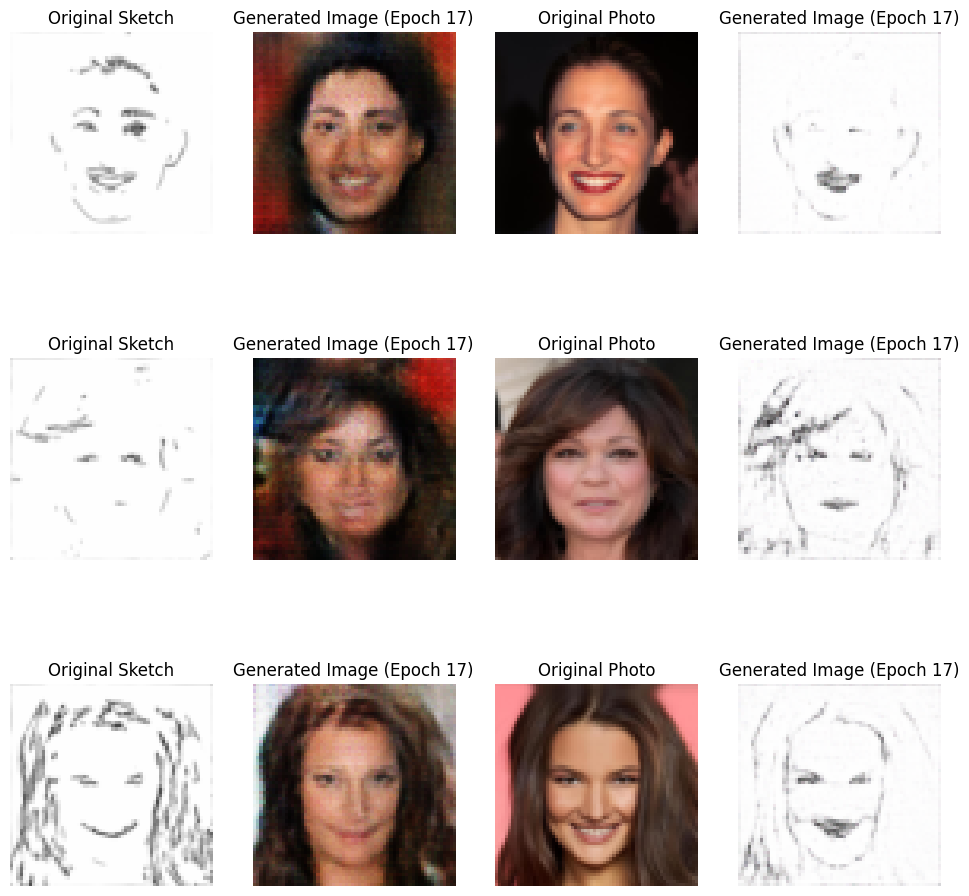

Epoch [18/20]


100%|██████████| 162/162 [02:36<00:00,  1.03it/s, H_fake=0.413, H_real=0.587]


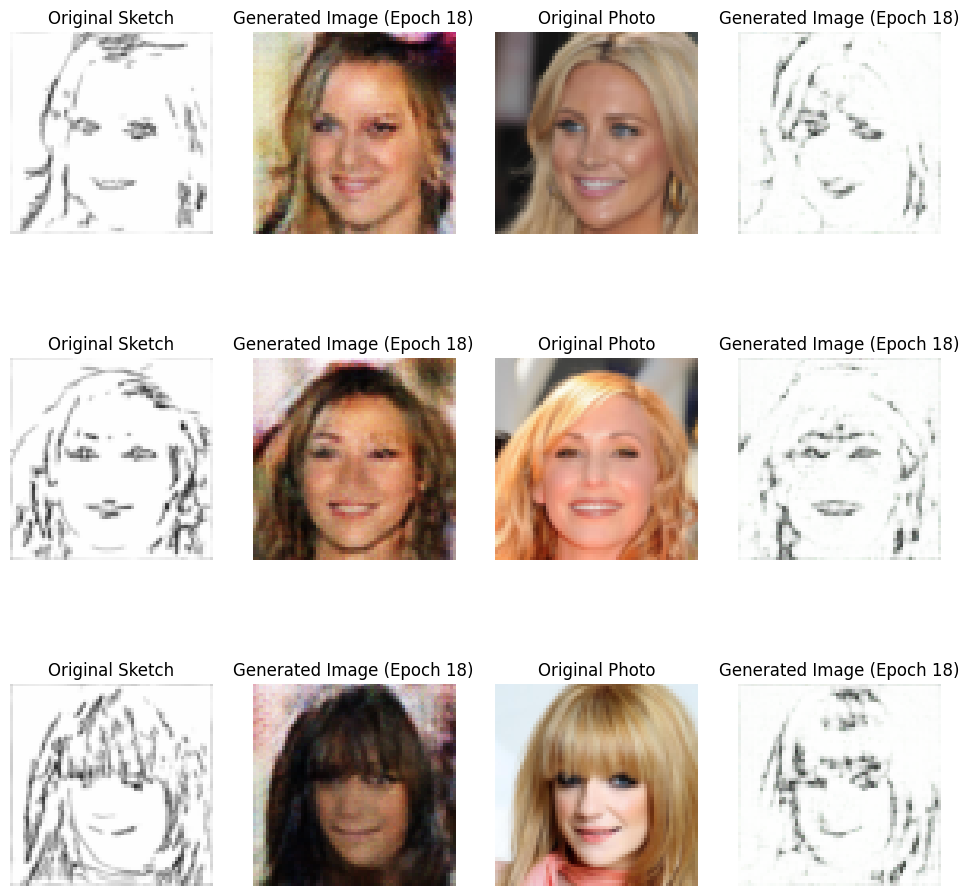

Epoch [19/20]


100%|██████████| 162/162 [02:37<00:00,  1.03it/s, H_fake=0.411, H_real=0.588]


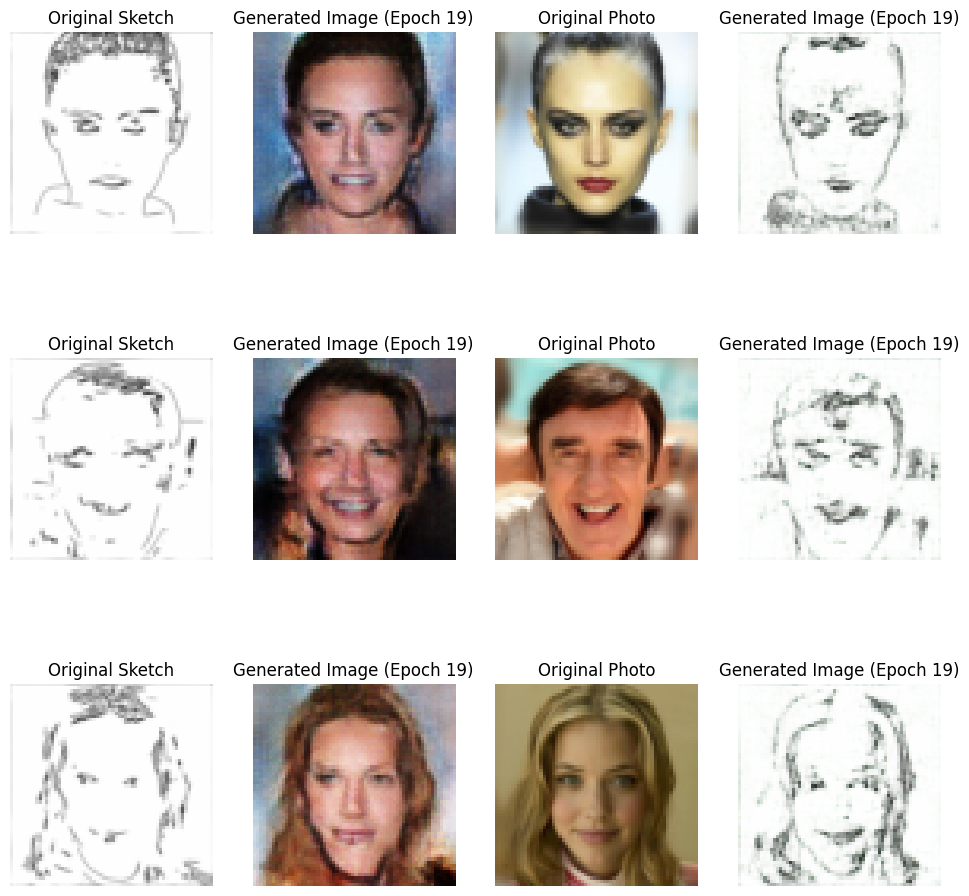

Epoch [20/20]


100%|██████████| 162/162 [02:38<00:00,  1.02it/s, H_fake=0.409, H_real=0.591]


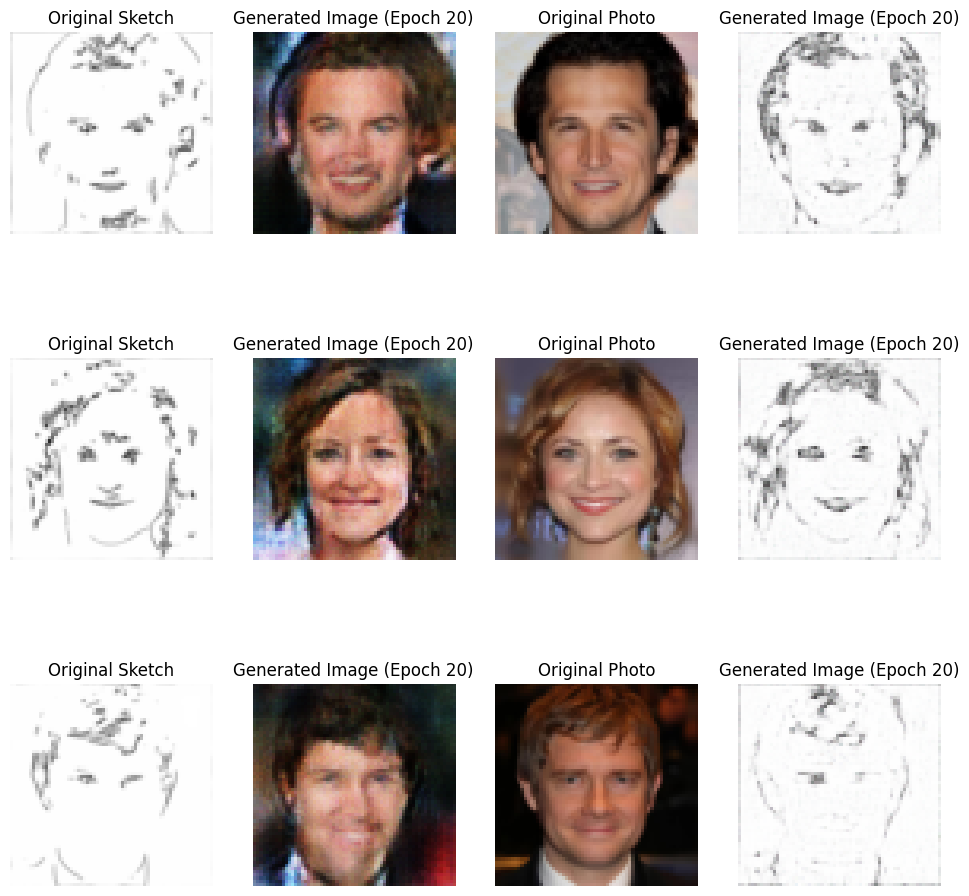

Training completed.


In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Initialize models, optimizers, and loss functions
disc_H=Discriminator(in_channels=3).to(device)
disc_Z=Discriminator(in_channels=3).to(device)
gen_Z=Generator(img_channels=3).to(device)
gen_H=Generator(img_channels=3).to(device)

opt_disc=optim.Adam(
    itertools.chain(disc_H.parameters(),disc_Z.parameters()),lr=2e-4,betas=(0.5,0.999)
)
opt_gen=optim.Adam(
    itertools.chain(gen_H.parameters(),gen_Z.parameters()),lr=2e-4,betas=(0.5,0.999)
)

L1_LOSS=nn.L1Loss()
MSE_LOSS=nn.MSELoss()

#Mixed precision scaler
g_scaler=GradScaler()
d_scaler=GradScaler()

#Function to save generated images
def save_generated_images(gen_H,gen_Z,epoch,dataloader,device,num_images=3):
    gen_H.eval()
    gen_Z.eval()
    sketch_images,original_images=next(iter(dataloader))
    sketch_images=sketch_images[:num_images].to(device)
    original_images=original_images[:num_images].to(device)
    #Generate fake images
    with torch.no_grad():
        fake1=gen_H(sketch_images)
        fake2=gen_Z(original_images)
    #Convert to NumPy format for plotting
    def denorm(tensor):
        tensor=tensor*0.5+0.5
        return tensor.cpu().numpy()
    fig,axes=plt.subplots(num_images,4,figsize=(12,12))
    for i in range(num_images):
        axes[i,0].imshow(np.transpose(denorm(sketch_images[i]),(1,2,0)))
        axes[i,0].set_title("Original Sketch")
        axes[i,0].axis("off")

        axes[i,1].imshow(np.transpose(denorm(fake1[i]),(1,2,0)))
        axes[i,1].set_title(f"Generated Image (Epoch {epoch})")
        axes[i,1].axis("off")

        axes[i,2].imshow(np.transpose(denorm(original_images[i]),(1,2,0)))
        axes[i,2].set_title("Original Photo")
        axes[i,2].axis("off")

        axes[i,3].imshow(np.transpose(denorm(fake2[i]),(1,2,0)))
        axes[i,3].set_title(f"Generated Image (Epoch {epoch})")
        axes[i,3].axis("off")

    plt.show()
    gen_H.train()
    gen_Z.train()

# raining Loop
NUM_EPOCHS=20
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    train(disc_H,disc_Z,gen_Z,gen_H,train_loader,opt_disc,opt_gen,L1_LOSS,MSE_LOSS,d_scaler,g_scaler,device)
    save_generated_images(gen_H,gen_Z,epoch+1,train_loader,device)
print("Training completed.")


In [9]:
#Save the models after training
torch.save({
    'gen_H_state_dict': gen_H.state_dict(),
    'gen_Z_state_dict': gen_Z.state_dict(),
    'disc_H_state_dict': disc_H.state_dict(),
    'disc_Z_state_dict': disc_Z.state_dict(),
    'opt_gen_state_dict': opt_gen.state_dict(),
    'opt_disc_state_dict': opt_disc.state_dict(),
}, f'models_epoch_{NUM_EPOCHS}.pth')

print("Training completed and models saved.")

Training completed and models saved.
